In [1]:
!pip install shapely
!pip install shapely scikit-image


In [2]:
import networkx as nx

def create_custom_tree():
    # Create 4 high-degree nodes
    G = nx.Graph()
    for i in range(4):
        G.add_node(i)

    # Connect leaves
    leaf_id = 4
    for hub in range(4):
        for _ in range(1 if hub == 3 else 2):  # 6 leaves in total
            G.add_edge(hub, leaf_id)
            leaf_id += 1

    # Connect hubs to form a tree
    G.add_edge(0, 1)
    G.add_edge(1, 2)
    G.add_edge(2, 3)
    return G


In [3]:
def layout_graph(G):
    return nx.spring_layout(G, seed=42)

G = create_custom_tree()
pos = layout_graph(G)


In [4]:
import numpy as np

def add_random_points_around_graph(G, pos, n_points=300, noise_scale=0.05, seed=None):
    rng = np.random.default_rng(seed)
    cloud_points = []

    # Points near vertices
    for p in pos.values():
        local_noise = p + rng.normal(scale=noise_scale, size=(n_points // 2 // len(pos), 2))
        cloud_points.append(local_noise)

    # Points near edges
    for u, v in G.edges():
        p1, p2 = pos[u], pos[v]
        t_vals = rng.uniform(0, 1, size=n_points // 2 // G.number_of_edges())
        samples = np.outer(1 - t_vals, p1) + np.outer(t_vals, p2)
        samples += rng.normal(scale=noise_scale, size=samples.shape)
        cloud_points.append(samples)

    return np.vstack(cloud_points)

cloud = add_random_points_around_graph(G, pos, seed=1990)


In [5]:
from shapely.ops import unary_union, polygonize
from shapely.geometry import MultiLineString, Polygon
from scipy.spatial import Delaunay
import math

def alpha_shape(points, alpha):
    if len(points) < 4:
        return Polygon(points).convex_hull

    tri = Delaunay(points)
    edges = set()
    edge_points = []

    for ia, ib, ic in tri.simplices:
        pa, pb, pc = points[ia], points[ib], points[ic]
        a = np.linalg.norm(pb - pa)
        b = np.linalg.norm(pc - pb)
        c = np.linalg.norm(pa - pc)

        s = (a + b + c) / 2.0
        area = math.sqrt(s * (s - a) * (s - b) * (s - c))
        if area == 0:
            continue
        circum_r = a * b * c / (4.0 * area)

        if circum_r < 1.0 / alpha:
            for i, j in [(ia, ib), (ib, ic), (ic, ia)]:
                if (i, j) not in edges and (j, i) not in edges:
                    edges.add((i, j))
                    edge_points.append((tuple(points[i]), tuple(points[j])))

    m = MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return unary_union(triangles)

shape = alpha_shape(cloud, alpha=10)


In [6]:
from shapely.geometry import LineString, MultiLineString
from shapely.ops import unary_union
from scipy.spatial import Voronoi
def compute_medial_axis_from_polygon(shape, sample_density=1):
    """
    Accepts Polygon or MultiPolygon and returns medial axis as MultiLineString.
    """
    if shape.geom_type == 'MultiPolygon':
        all_axes = [compute_medial_axis_from_polygon(poly, sample_density) for poly in shape.geoms]
        return unary_union(all_axes)

    # Continue as usual for a single Polygon
    boundary = shape.exterior
    length = boundary.length
    num_samples = max(500, int(length * sample_density))
    distances = np.linspace(0, length, num_samples)
    sampled_points = [boundary.interpolate(d) for d in distances]
    coords = np.array([[p.x, p.y] for p in sampled_points])

    # Voronoi and medial axis computation
    vor = Voronoi(coords)
    medial_edges = []
    for start, end in vor.ridge_vertices:
        if start == -1 or end == -1:
            continue
        p1, p2 = vor.vertices[start], vor.vertices[end]
        segment = LineString([p1, p2])
        if shape.contains(segment):
            medial_edges.append(segment)

    return unary_union(medial_edges)

medial_axis = compute_medial_axis_from_polygon(shape)

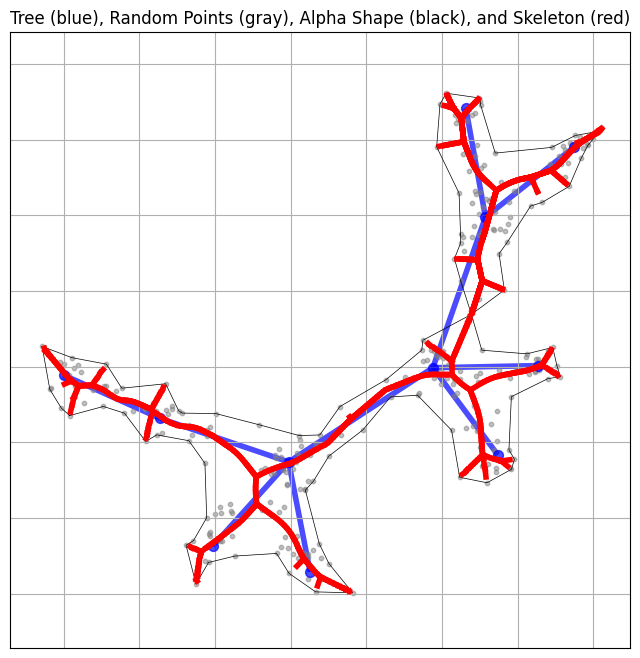

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G, pos, edge_color='blue', width=4, alpha=0.7)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.7)
plt.scatter(cloud[:, 0], cloud[:, 1], color='gray', s=10, alpha=0.5)

if shape.geom_type == "Polygon":
    x, y = shape.exterior.xy
    plt.plot(x, y, color='black', linewidth=0.5)
elif shape.geom_type == "MultiPolygon":
    for poly in shape.geoms:
        x, y = poly.exterior.xy
        plt.plot(x, y, color='black', linewidth=0.5)

if isinstance(medial_axis, LineString):
    plt.plot(*medial_axis.xy, color='red', linewidth=4)
elif isinstance(medial_axis, MultiLineString):
    for line in medial_axis.geoms:
        plt.plot(*line.xy, color='red', linewidth=4)

plt.title('Tree (blue), Random Points (gray), Alpha Shape (black), and Skeleton (red)')
plt.grid(True)
plt.axis('equal')
plt.show()
